# 5.1 Setup

### 说明：此环节有两处与R语言不同：
### 1. R语言使用p_load函数来自动安装缺失库以及导入库，Python语言需要手动配置环境，如果缺失库，可以使用   ! pip install [package_name]  来安装；
### 2. R语言在setup环节设置了并行，Python语言在这个环节没有进行设置，而是在后续使用dask包来进行并行计算。

We will need to use several Python packages to optimize our workflow and fit mixed effects models. 

In [1]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask
import time

from dask.distributed import Client
from itertools import product

We will also set the pseudo-random number generator seed to 2138 to make the stochastic components of our simulations reproducible.

In [2]:
np.random.seed(2138)

# 5.2 Data simulation step by step

### 说明：此环节有两处与R语言不同：
### 1. 模型不同，没有体现主体的随机截距和随机斜率之间的相关性；
### 2. 没有使用类似R语言的broom.mixed::tidy()函数来呈现模型拟合结果。

To give an overview of the power simulation task, we will simulate data from a design with crossed random factors of subjects and songs (see Power of What? for design details), fit a model to the simulated data, recover from the model output the parameter values we put in, calculate power, and finally automate the whole process so that we can calculate power for different effect sizes. Much of the general workflow here is borrowed from DeBruine & Dale (2021) Understanding Mixed-Effects Models through Simulation. We’ll start by writing code that simulates datasets under the alternative hypothesis.

## 5.2.1 Establish the simulation parameters

Before we start, let’s set some global parameters for our power simulations. Since simulations can take a long time to run, we’ll use 30 replications here as an example, but we recommend increasing this number to at least 1000 replications for a more accurate final power calculation.

In [3]:
# number of simulation replicates for power calculation
reps = 30

# specified alpha for power calculation
alpha = 0.05

## 5.2.2 Establish the data-generating parameters

The first thing to do is to set up the parameters that govern the process we assume gave rise to the data - the data-generating process, or DGP. We previously decided upon the the data-generating parameters (see Power of What?), so we just need to code them here.

In [4]:
# set all data-generating parameters
beta_0 = 60  # intercept; i.e., the grand mean
beta_1 = 5   # slope; i.e, effect of category
omega_0 = 3  # by-song random intercept sd
tau_0 = 7    # by-subject random intercept sd
tau_1 = 4    # by-subject random slope sd
rho = 0.2    # correlation between intercept and slope
sigma = 8    # residual (error) sd

## 5.2.3 Simulate the sampling process

Next, we will simulate the sampling process for the data. First, let’s define parameters related to the number of observations.

In [5]:
# set number of subjects and songs
n_subj = 25  # number of subjects
n_pop = 15   # number of songs in pop category
n_rock = 15  # number of songs in rock category

### 5.2.3.1 Simulate the sampling of songs

We need to create a table listing each song \(i\), which category it is in (rock or pop), and its random effect \(O_{0i}\). The latter is sampled from a univariate normal distribution using the function np.random.normal().

In [6]:
# simulate a sample of songs
songs = pd.DataFrame({
    'song_id': range(1, n_pop + n_rock + 1),
    'category': ['pop']*n_pop + ['rock']*n_rock,
    'genre_i': [0]*n_pop + [1]*n_rock,
    'O_0i': np.random.normal(0, omega_0, n_pop + n_rock)
})

print(songs.head(10))

   song_id category  genre_i      O_0i
0        1      pop        0 -1.803722
1        2      pop        0 -4.618354
2        3      pop        0 -4.847097
3        4      pop        0 -1.097951
4        5      pop        0 -1.394909
5        6      pop        0  2.424235
6        7      pop        0 -3.956914
7        8      pop        0  0.873891
8        9      pop        0  3.318065
9       10      pop        0  5.513671


### 5.2.3.2 Simulate the sampling of subjects

Now we simulate the sampling of participants, which results in table listing each individual and their two correlated random effects (a random intercept and random slope). To do this, we must sample \({T_{0j}, T_{1j}}\) pairs - one for each subject - from a bivariate normal distribution.

We will use the function np.random.multivariate_normal(), which generates a table of n simulated values from a multivariate normal distribution by specifying the means and covariance matrix(cov).

In [7]:
# simulate a sample of subjects

# sample from a multivariate normal distribution
mean = [0, 0]  # means for random effects are always 0
cov = [[tau_0**2, rho*tau_0*tau_1], [rho*tau_0*tau_1, tau_1**2]]  # set covariance matrix

random_effects = np.random.multivariate_normal(mean, cov, n_subj)

subjects = pd.DataFrame(random_effects, columns=['T_0j', 'T_1j'])
subjects['subj_id'] = range(1, n_subj + 1) # add subject IDs

print(subjects.head(10))

        T_0j      T_1j  subj_id
0  -0.547564 -2.796419        1
1 -10.695092 -3.700622        2
2   3.387493 -7.940628        3
3   4.344241  0.531463        4
4   6.461586  5.260280        5
5 -12.373764 -1.387928        6
6   0.352194 -3.990547        7
7  -6.962734  2.358670        8
8  -2.636463 -0.370637        9
9   0.619930 -4.416671       10


### 5.2.3.3 Check the simulated values

Let’s do a quick sanity check by comparing our simulated values to the parameters we used as inputs. Because the sampling process is stochastic, we shouldn’t expect that these will exactly match for any given run of the simulation.

In [8]:
check_values = pd.DataFrame({
    'parameter': ['omega_0', 'tau_0', 'tau_1', 'rho'],
    'value': [omega_0, tau_0, tau_1, rho],
    'simulated': [songs['O_0i'].std(), subjects['T_0j'].std(), subjects['T_1j'].std(), subjects['T_0j'].corr(subjects['T_1j'])]
})

print(check_values)

  parameter  value  simulated
0   omega_0    3.0   3.372345
1     tau_0    7.0   5.648262
2     tau_1    4.0   4.439518
3       rho    0.2   0.063860


### 5.2.3.4 Simulate trials

Since all subjects rate all songs (i.e., the design is fully crossed) we can set up a table of trials by including every possible combination of the rows in the subjects and songs tables. Each trial has random error associated with it, reflecting fluctuations in trial-by-trial ratings due to unkown factors. We simulate this by sampling values from a univariate normal distribution with a mean of 0 and a standard deviation of sigma.

In [9]:
# cross subject and song IDs; add an error term
trials = subjects.assign(key=1).merge(songs.assign(key=1), on='key').drop(columns='key')
trials['e_ij'] = np.random.normal(0, sigma, len(trials))

print(trials.head(10))

       T_0j      T_1j  subj_id  song_id category  genre_i      O_0i       e_ij
0 -0.547564 -2.796419        1        1      pop        0 -1.803722   6.954841
1 -0.547564 -2.796419        1        2      pop        0 -4.618354  -6.588163
2 -0.547564 -2.796419        1        3      pop        0 -4.847097   5.226969
3 -0.547564 -2.796419        1        4      pop        0 -1.097951 -11.285800
4 -0.547564 -2.796419        1        5      pop        0 -1.394909   2.418785
5 -0.547564 -2.796419        1        6      pop        0  2.424235  -7.579483
6 -0.547564 -2.796419        1        7      pop        0 -3.956914  -2.553524
7 -0.547564 -2.796419        1        8      pop        0  0.873891  12.726906
8 -0.547564 -2.796419        1        9      pop        0  3.318065  -6.371494
9 -0.547564 -2.796419        1       10      pop        0  5.513671  13.508966


### 5.2.3.5 Calculate response values

With this resulting trials table, in combination with the constants beta_0 and beta_1, we have the full set of values that we need to compute the response variable liking_ij according the linear model we defined previously (see Power of What?).

In [10]:
dat_sim = trials.copy()
dat_sim['liking_ij'] = beta_0 + dat_sim['T_0j'] + dat_sim['O_0i'] + (beta_1 + dat_sim['T_1j']) * dat_sim['genre_i'] + dat_sim['e_ij']
dat_sim = dat_sim[['subj_id', 'song_id', 'category', 'genre_i', 'liking_ij']]

print(dat_sim.head(10))

   subj_id  song_id category  genre_i  liking_ij
0        1        1      pop        0  64.603556
1        1        2      pop        0  48.245919
2        1        3      pop        0  59.832308
3        1        4      pop        0  47.068685
4        1        5      pop        0  60.476312
5        1        6      pop        0  54.297188
6        1        7      pop        0  52.941998
7        1        8      pop        0  73.053233
8        1        9      pop        0  56.399007
9        1       10      pop        0  78.475074


### 5.2.3.6 Plot the data

Let’s visualize the distribution of the response variable for each of the two song genres and superimpose the simulated parameter estimates for the means of these two groups.

C:\Users\DELL\AppData\Local\Temp\ipykernel_10516\951862498.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='category', y='liking_ij', data=dat_sim, estimator=np.mean, ci=None, color='black')


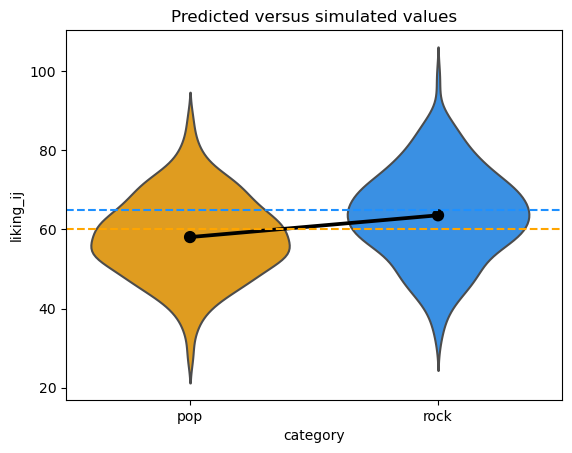

In [11]:
palette = {'pop': 'orange', 'rock': 'dodgerblue'}

# actual data
sns.violinplot(x='category', y='liking_ij', data=dat_sim, palette=palette, inner=None, alpha=0.5)
sns.pointplot(x='category', y='liking_ij', data=dat_sim, estimator=np.mean, ci=None, color='black')

# predicted means
plt.axhline(y=(beta_0 + 0*beta_1), color='orange', linestyle='dashed')
plt.axhline(y=(beta_0 + 1*beta_1), color='dodgerblue', linestyle='dashed')

plt.title("Predicted versus simulated values")
plt.show()

## 5.2.4 Analyze the simulated data

Now we can analyze our simulated data in a linear mixed effects model using the function mixedlm from the {statsmodels} package. The formula and vc_formula in mixedlm() map onto how we calculated our liking_ij outcome variable above. 

The terms in formula are as follows:
liking_ij is the response.
1 is the intercept (beta_0), which is the mean of the response for the pop genre of songs (because we used dummy coding for the genre_i term).
genre_i is the dummy coded variable identifying whether song \(i\) belongs to the pop or rock genre.

The terms in vc_formula are as follows:
0 + C(song_id) specifies a song-specific random intercept (O_0i).
0 + C(subj_id) specifies a subject-specific random intercept (T_0j).
0 + C(subj_id):genre_i specifies the subject specific random slope of the genre category (T_1j).

However, due to the inability of the function mixedlm(), the module did not indicate the correlation between subject-specific random intercept and the subject specific random slope of the genre category.

Now we can estimate the model.

In [12]:
# fit a linear mixed-effects model to data
form = 'liking_ij ~ 1 + genre_i'
dat_sim['groups'] = 1
vcf = {'song_id':'0 + C(song_id)', 'subj_id':'0 + C(subj_id)', 'genre_i': '0 + C(subj_id):genre_i'}
model = smf.mixedlm(form, groups=dat_sim['groups'], vc_formula=vcf, re_formula='0', data=dat_sim)

mod_sim = model.fit()
print(mod_sim.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: liking_ij 
No. Observations: 750     Method:             REML      
No. Groups:       1       Scale:              66.4110   
Min. group size:  750     Log-Likelihood:     -2708.1155
Max. group size:  750     Converged:          Yes       
Mean group size:  750.0                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     58.078    1.494 38.873 0.000 55.150 61.007
genre_i        5.505    1.631  3.376 0.001  2.309  8.701
genre_i Var   22.355    1.106                           
song_id Var   10.578    0.443                           
subj_id Var   33.748    1.353                           



# 5.3 Data simulation automated

Now that we’ve tested the data generating code, we can put it into a function so that it’s easy to run it repeatedly.

In [13]:
def sim_data(n_subj=25, n_pop=15, n_rock=15, beta_0=60, beta_1=5, omega_0=3, tau_0=7, tau_1=4, rho=0.2, sigma=8):
    songs = pd.DataFrame({
        'song_id': np.arange(n_pop + n_rock),
        'category': np.repeat(["pop", "rock"], [n_pop, n_rock]),
        'genre_i': np.repeat([0, 1], [n_pop, n_rock]),
        'O_0i': np.random.normal(0, omega_0, n_pop + n_rock)
    })

    random_effects = np.random.multivariate_normal([0, 0], [[tau_0**2, rho*tau_0*tau_1], [rho*tau_0*tau_1, tau_1**2]], n_subj)
    subjects = pd.DataFrame(random_effects, columns=['T_0j', 'T_1j'])
    subjects['subj_id'] = np.arange(1, n_subj + 1)

    trials = pd.merge(subjects, songs, how='cross')
    trials['e_ij'] = np.random.normal(0, sigma, len(trials))
    trials['liking_ij'] = beta_0 + trials['T_0j'] + trials['O_0i'] + (beta_1 + trials['T_1j']) * trials['genre_i'] + trials['e_ij']

    return trials[['subj_id', 'song_id', 'category', 'genre_i', 'liking_ij']]

# 5.4 Power calculation single run

### 说明：此环节有一处与R语言不同：
### 1. 没有设置过滤报警信息。

We can wrap the data generating function and modeling code in a new function single_run() that returns a table of the analysis results for a single simulation run.

In [14]:
def single_run(n_subj=25, n_pop=15, n_rock=15, beta_0=60, beta_1=5, omega_0=3, tau_0=7, tau_1=4, rho=0.2, sigma=8):
    dat_sim = sim_data(n_subj, n_pop, n_rock, beta_0, beta_1, omega_0, tau_0, tau_1, rho, sigma)
    
    dat_sim['groups'] = 1
    mod_sim = smf.mixedlm('liking_ij ~ 1 + genre_i', groups=dat_sim['groups'], 
                          vc_formula={'song_id':'0 + C(song_id)', 'subj_id':'0 + C(subj_id)', 'genre_i': '0 + C(subj_id):genre_i'}, 
                          re_formula='0', data=dat_sim).fit()
    
    df = mod_sim.summary().tables[1]
    df['p_value'] = mod_sim.pvalues
    return df[['Coef.', 'Std.Err.', 'p_value']]

Let’s test that our new single_run() function performs as expected.

In [15]:
# run one model with default parameters
single_run()

,Coef.,Std.Err.,p_value
Intercept,62.364,1.620,0.000000
genre_i,1.794,1.454,0.217012
genre_i Var,15.056,0.854,0.027138
song_id Var,8.783,0.387,0.004477
subj_id Var,46.691,1.848,0.001541


In [16]:
# run one model with new parameters
single_run(n_pop = 10, n_rock = 50, beta_1 = 2)

,Coef.,Std.Err.,p_value
Intercept,60.065,1.635,1.824465e-295
genre_i,2.934,1.308,2.494009e-02
genre_i Var,14.922,0.811,1.634819e-02
song_id Var,6.946,0.230,8.011783e-05
subj_id Var,43.595,1.826,1.830974e-03


# 5.5 Power calculation automated

### 说明：此环节有两处与R语言不同：
### 1. R语言使用future_map_dfr()函数循环调用single_run()函数，Python直接使用自带的for语句进行循环；
### 2. R语言在setup环节即设定了并行运算，而Python语言在此环节调用dask库进行并行运算：首先定义延迟版本的single_run()函数，在调用delayed_single_run()函数的时候，函数并不会立刻执行，因此可以很方便地使用for循环语句将需要执行的函数存入任务列表中，再调用dask.compute()函数并行计算列表内存储的任务。

To get an accurate estimation of power, we need to run the simulation many times. Here we use the package dask to parallelize existing code to speed-up iterative processes. 

We use dask.delayed function to decorate single_run() so that it operates lazily, then call the delayed version repeatedly using for statement, and finally call dask.compute function to get the result of simulations.

In [17]:
client = Client()

@dask.delayed
def delayed_single_run(n_subj=25, n_pop=15, n_rock=15, beta_0=60, beta_1=5, omega_0=3, tau_0=7, tau_1=4, rho=0.2, sigma=8):
    df = single_run(n_subj, n_pop, n_rock, beta_0, beta_1, omega_0, tau_0, tau_1, rho, sigma)
    df = df.assign(n_subj=n_subj, n_pop=n_pop, n_rock=n_rock, beta_1=beta_1)
    return df

sims = [delayed_single_run() for _ in range(reps)]
sims_result = dask.compute(*sims)

sims_df = pd.concat(sims_result).reset_index().rename(columns={'index':'term'})

We can finally calculate power for our parameter of interest beta_1(denoted in the model output table as the term genre_i) by filtering to keep only that term and the calculating the proportion of times the \(p\)-value is below the alpha (0.05) threshold.

In [18]:
genre_i_sims = sims_df[sims_df['term'] == 'genre_i']
mean_estimate = genre_i_sims['Coef.'].astype(float).mean()
mean_se = genre_i_sims['Std.Err.'].astype(float).mean()
power = (genre_i_sims['p_value'].astype(float) < alpha).mean()

print(f"Mean estimate: {mean_estimate}")
print(f"Mean standard error: {mean_se}")
print(f"Power: {power}")

Mean estimate: 5.037033333333333
Mean standard error: 1.4391333333333336
Power: 1.0


## 5.5.1 Check false positive rate

We can do a sanity check to see if our simulation is performing as expected by checking the false positive rate (Type I error rate). We set the effect of genre_ij (beta_1) to 0 to calculate the false positive rate, which is the probability of concluding there is an effect when there is no actual effect in the population.

In [19]:
sims_fp = [delayed_single_run(beta_1=0) for _ in range(reps)]
sims_fp_result = dask.compute(*sims_fp)

sims_fp_df = pd.concat(sims_fp_result).reset_index().rename(columns={'index':'term'})

In [20]:
(sims_fp_df[sims_fp_df['term'] == 'genre_i']['p_value'].astype(float) < alpha).mean()

0.03333333333333333

Ideally, the false positive rate will be equal to alpha, which we set at 0.05.

# 5.6 Power for different effect sizes

### 说明：此环节有两处与R语言不同：
### 1. R语言使用future_pmap_dfr()，将参数的各种排列组合传入函数进行运算，在Python语言中，使用product函数进行参数的排列组合，使用for循环将参数输入延迟版single_run函数，然后使用dask.compute执行并行计算；
### 2. R语言定义了parameter_search()，函数可以实现参数各排列组合的单次模拟，尔后只需重复调用parameter_search()即可实现参数各排列组合的多次模拟，但是在Python语言中，parameter_search()函数已经调用了延迟版函数，不能再包装成延迟版函数，因此在进行参数各排列组合的多次模拟时，无法实现使用dask库重复调用parameter_search()，只能使用两层循环的方式来调用delayed_single_run()。

In real life, we will not know the effect size of our quantity of interest and so we will need to repeatedly perform the power analysis over a range of different plausible effect sizes. Perhaps we might also want to calculate power as we vary other data-generating parameters, such as the number of pop and rock songs sampled and the number of subjects sampled. We can create a table that combines all combinations of the parameters we want to vary in a grid.

In [21]:
# grid of paramater values of interest
params = {
    'n_subj': [10, 50],
    'n_pop': [10, 40],
    'n_rock': [10, 40],
    'beta_1': [1, 3, 5]
}

We can now wrap delayed_single_run() function within a more general function parameter_search() that takes the grid of parameter values as input and uses the for statement to iterate over each row of parameter values in pgrid and feed them into delayed_single_run().

In [22]:
# fit the models over the parameters
def parameter_search(params):
    sims = []
    pgrid = pd.DataFrame(list(product(*params.values())), columns=params.keys())

    # iterate over the grid of parameter values
    for _, row in pgrid.iterrows():
        sims.append(delayed_single_run(
            n_subj=row['n_subj'], # plug each row of parameter values into single_run()
            n_pop=row['n_pop'],
            n_rock=row['n_rock'],
            beta_1=row['beta_1']
        ))
    return pd.concat(dask.compute(*sims)).reset_index().rename(columns={'index':'term'})

If we call parameter_search() it will return a single replication of simulations for each combination of parameter values in pgrid.

In [23]:
parameter_search(params)

,term,Coef.,Std.Err.,p_value,n_subj,n_pop,n_rock,beta_1
0,Intercept,60.099,2.753,1.166542e-105,10,10,10,1
1,genre_i,4.608,1.704,6.853703e-03,10,10,10,1
2,genre_i Var,6.625,3.579,8.106672e-01,10,10,10,1
3,song_id Var,5.240,0.412,9.966767e-02,10,10,10,1
4,subj_id Var,64.575,4.900,8.805737e-02,10,10,10,1
...,...,...,...,...,...,...,...,...
115,Intercept,60.654,1.219,0.000000e+00,50,40,40,5
116,genre_i,3.154,1.002,1.645671e-03,50,40,40,5
117,genre_i Var,16.425,0.493,4.036671e-05,50,40,40,5
118,song_id Var,12.187,0.269,2.429500e-08,50,40,40,5


To run multiple replication of simulations for each combination of parameter values in pgrid, we can use the for statement to iterate over each row of parameter values in pgrid for the number of times specified by reps. Fair warning, this will take some time if you have set a high number of replications!

In [24]:
sims_params = []
pgrid = pd.DataFrame(list(product(*params.values())), columns=params.keys())

for _ in range(reps):
    for _, row in pgrid.iterrows():
        sims_params.append(delayed_single_run(
            n_subj=row['n_subj'],
            n_pop=row['n_pop'],
            n_rock=row['n_rock'],
            beta_1=row['beta_1']
        ))

sims_params_result = dask.compute(*sims_params)

sims_params_df = pd.concat(sims_params_result).reset_index().rename(columns={'index':'term'})
sims_params_df

,term,Coef.,Std.Err.,p_value,n_subj,n_pop,n_rock,beta_1
0,Intercept,58.053,2.838,5.511683e-93,10,10,10,1
1,genre_i,-2.281,1.947,2.414988e-01,10,10,10,1
2,genre_i Var,9.586,1.345,3.832907e-01,10,10,10,1
3,song_id Var,7.480,0.598,1.263574e-01,10,10,10,1
4,subj_id Var,66.386,4.240,5.554743e-02,10,10,10,1
...,...,...,...,...,...,...,...,...
3595,Intercept,60.772,1.196,0.000000e+00,50,40,40,5
3596,genre_i,3.238,1.051,2.062002e-03,50,40,40,5
3597,genre_i Var,26.370,0.961,5.941680e-04,50,40,40,5
3598,song_id Var,10.268,0.279,3.952983e-06,50,40,40,5


Now, as before, we can calculate power. But this time we’ll group by all of the parameters we manipulated in pgrid, so that we can get power estimates for all combinations of parameter values.

In [25]:
sims_table = sims_params_df.query("term == 'genre_i'").groupby(['term', 'n_subj', 'n_pop', 'n_rock', 'beta_1']).agg(
    mean_estimate=pd.NamedAgg(column='Coef.', aggfunc=lambda x: x.astype(float).mean()),
    mean_se=pd.NamedAgg(column='Std.Err.', aggfunc=lambda x: x.astype(float).mean()),
    power=pd.NamedAgg(column='p_value', aggfunc=lambda x: (x.astype(float) < alpha).mean())
).reset_index()

Here's a formatted table that summarizes the output from the power simulation.

In [26]:
sims_table

,term,n_subj,n_pop,n_rock,beta_1,mean_estimate,mean_se,power
0,genre_i,10,10,10,1,0.893933,2.185367,0.066667
1,genre_i,10,10,10,3,2.464867,2.346400,0.133333
2,genre_i,10,10,10,5,5.879133,2.286667,0.666667
3,genre_i,10,10,40,1,0.811833,2.192400,0.000000
4,genre_i,10,10,40,3,2.709033,2.160633,0.166667
5,genre_i,10,10,40,5,4.793833,2.228867,0.600000
6,genre_i,10,40,10,1,0.528000,2.230733,0.033333
7,genre_i,10,40,10,3,2.933533,2.246333,0.200000
8,genre_i,10,40,10,5,5.025333,2.263767,0.666667
9,genre_i,10,40,40,1,1.221400,1.917933,0.066667


Here’s a graph that visualizes the output of the power simulation.

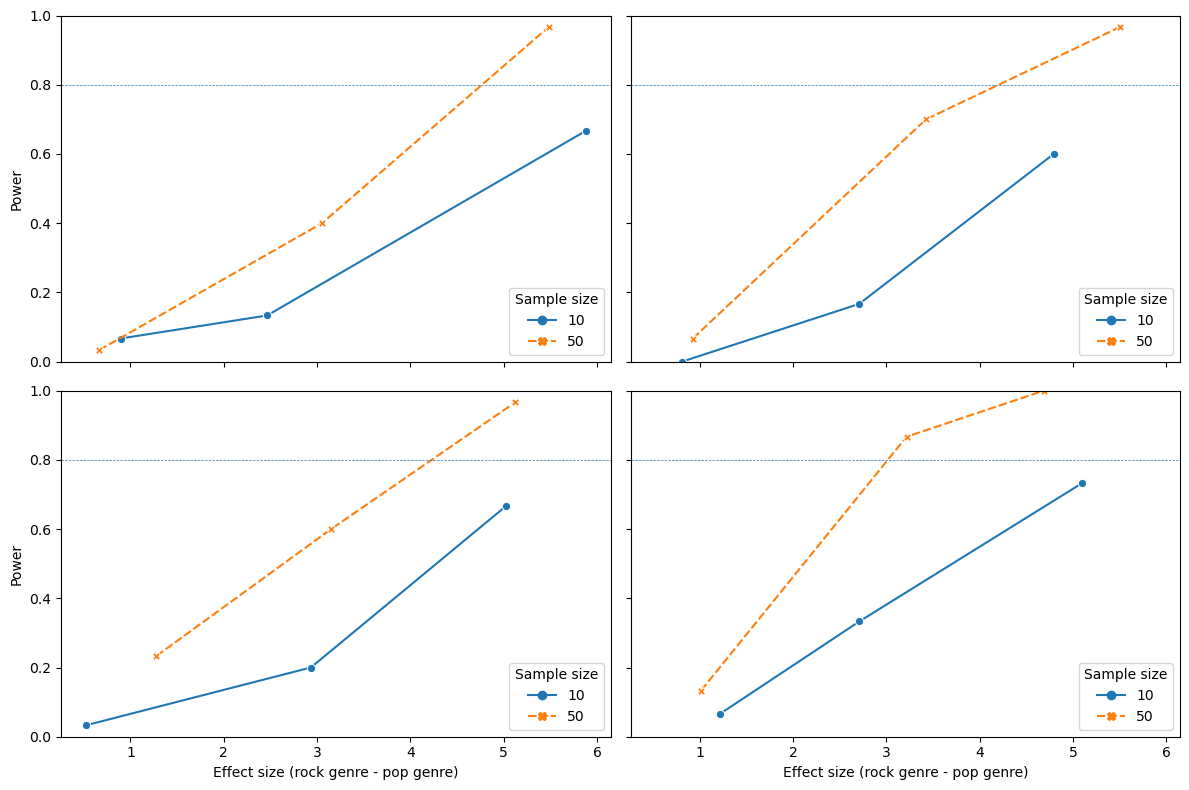

In [27]:
# 转换数据类型并修改标签
sims_table['n_subj'] = sims_table['n_subj'].astype(str)
sims_table['n_pop'] = 'n_pop: ' + sims_table['n_pop'].astype(str)
sims_table['n_rock'] = 'n_rock: ' + sims_table['n_rock'].astype(str)

# 创建子图
fig, axes = plt.subplots(len(sims_table['n_pop'].unique()), len(sims_table['n_rock'].unique()), figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

# 绘制子图
for i, (pop, rock) in enumerate(sims_table.groupby(['n_pop', 'n_rock'])):
    ax = axes[i]
    sns.lineplot(data=rock, x='mean_estimate', y='power', hue='n_subj', style='n_subj', markers=True, ax=ax)
    ax.axhline(y=0.8, linestyle='dashed', linewidth=0.5)
    # ax.set_title(f'{pop} x {rock}')
    ax.set_xlabel('Effect size (rock genre - pop genre)')
    ax.set_ylabel('Power')
    ax.set_ylim(0, 1)
    ax.legend(title='Sample size')

# 调整图表布局
plt.tight_layout()

# 显示图表
plt.show()